# Climate stripes: Fire Weather Index

In [97]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['font.serif'] = ['Times New Roman']
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import datetime as dt
import pandas as pd
import geopandas as gpd
import netCDF4 as nc4
import xarray as xr


In [98]:
# import helper functions
from helpers.helpers_plotting import plot_spi_timeseries, plot_precip_timeseries, create_diverging_colorscheme, plot_droughtmap#, plot_countrymap
from helpers.geodata import calculate_gridarea, grid2df, mask_gridpoints_in_polygon, mask_3darray
from helpers.helpers_ecmwf import load_grb_file
# get mask of grid points in countryshp


## Main settings

In [99]:
# settings
spi_levels = [-3, -2, -1.5, -1, -0.1, 0.1, 1, 1.5, 2, 3]
plot_type  = 'pcolormesh'
debug = True
#country = ["Somalia","Somaliland"]
#country_name = 'Somalia'
country_name = 'Australia'
country = [country_name]


In [100]:
# paths
ipath         = "data"
index         = "fwinx"
ref_period    = "1991to2020"
stream        = "moda"
window=12
ryyyy_start   = int(ref_period[:4])
ryyyy_end     = int(ref_period[6:10])
print(ryyyy_start)
print(ryyyy_end)
yyyy_start    = "1940"
yyyy_end      = "2023"
print(yyyy_start)
print(yyyy_end)

1991
2020
1940
2023


### Create color scheme

In [118]:
effis_color_list=['#8effb4','#c3df3e','#de9d09','#cd5c10','#9a000d','#2b0011']
eccharts_color_list=["#486d19","#30a053","#aedd78","#e4f4ac","#ffff84","#fdce8c","#f1895b","#e65b47","#db2f32","#bf5922","#723f31"]
use_effis_colors=False
if use_effis_colors:
    
    levels=[11.2,21.3,38,50,70]
    color_list=effis_color_list
else:
    
    levels=[0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 100] 
    color_list=eccharts_color_list

### Handle dates

In [102]:
dates = pd.date_range(start="1940-01-01",end="2024-01-01", freq='ME')
pdate_seq = [dt.datetime.strptime(str(i)[0:10], "%Y-%m-%d") for i in dates]

## Country data

### Read country shapefile

/var/folders/9d/fb0cyg554yn045qch38xt09m0000gn/T/ipykernel_19881/2285233557.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  countryshp = countryshpa.unary_union


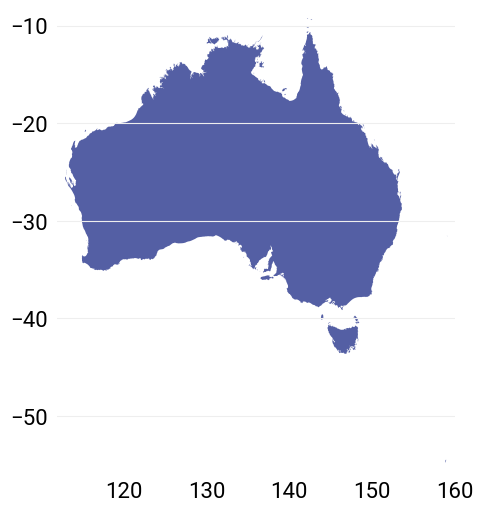

In [103]:
# Country to be selected
# read country shapes and select countries of interest
geoshp = gpd.read_file('data/ne_10m_admin_0_countries_lakes.shp')
countryshpa = geoshp.loc[ (geoshp.ADMIN.isin(country)), 'geometry' ]
if len(countryshpa) == 0:
    # Assume its a state
    geoshp = gpd.read_file('data/ne_10m_admin_1_states_provinces.shp')
    countryshpa = geoshp.loc[ (geoshp.name.isin(country)), 'geometry' ]
if debug:
    countryshpa.plot()
countryshp = countryshpa.unary_union
xlims = [(countryshp.bounds)[0]-0.5,(countryshp.bounds)[2]+0.5]
ylims = [(countryshp.bounds)[1]-0.5,(countryshp.bounds)[3]+0.5]

### Read landmask

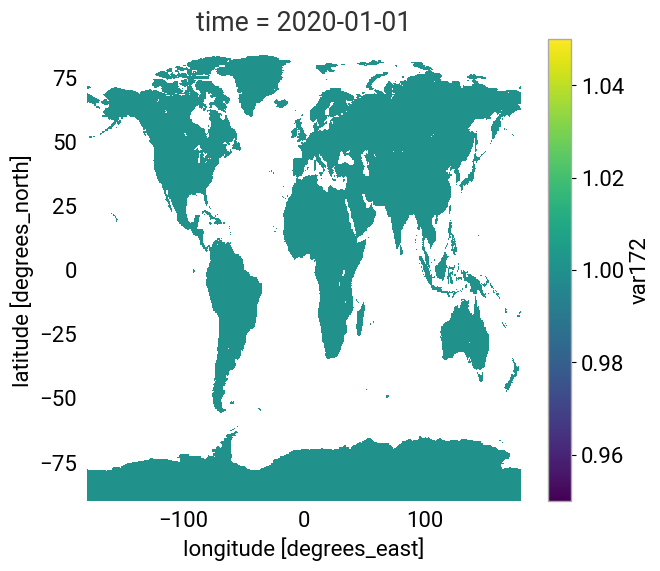

In [104]:
# read landmasks
varname       = "var172"
# binary mask (0/1)
ifile_name    = "landmask_era5_global.nc"
ifile         = os.path.join("data", ifile_name)
landmask_ecm = xr.open_dataset(ifile)[varname]
landmask_ecm = landmask_ecm.where( landmask_ecm.values == 1 )
landmask_ecm.plot()
nc_f = nc4.Dataset(ifile)
lats = np.asarray(nc_f["lat"][:])
lons = np.asarray(nc_f["lon"][:])
grid_lon, grid_lat = np.meshgrid(lons, lats)

# mask country data
gpoints = grid2df(grid_lon, grid_lat, ret='gpd', crs='epsg:4326')
mask    = mask_gridpoints_in_polygon(gpoints, countryshp, return_shape=grid_lon.shape, crs='epsg:4326')

## Reanalysis data

### Read fwinx data

ifile_name    = f"mean_fwi.grib2"
ifile         = os.path.join(ipath, ifile_name)
fwi        = load_grb_file(ifile)
# reshape to 3D array of dimension time x lat x lon for writing to netCDF
fwi        = fwi.reshape((fwi.shape[0], lats.size, lons.size))
#for it in range(len(precip.shape[0])):
#    # multiply with number of days in each month to get monthly totals
#    precip[it,:,:] = precip[it,:,:] * 


In [105]:
fwi=xr.open_dataset(f'{ipath}/mean_fwi.nc')
fwi

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 1008, lon: 1440, lat: 721)
Coordinates:
  * time     (time) datetime64[ns] 8kB 1940-01-04 1940-02-02 ... 2023-12-02
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    fwinx    (time, lat, lon) float32 4GB ...
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Oct 14 10:28:30 2024: cdo -R -f nc -setgridtype,regular...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

In [106]:
fwi.coords['lon'] = (fwi.coords['lon'] + 180) % 360 - 180
fwi = fwi.sortby(fwi.lon)
fwi

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 1008, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 8kB 1940-01-04 1940-02-02 ... 2023-12-02
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Data variables:
    fwinx    (time, lat, lon) float32 4GB ...
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Oct 14 10:28:30 2024: cdo -R -f nc -setgridtype,regular...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

In [107]:
fwi_country= mask_3darray(fwi['fwinx'].values, mask, maskval=1, fillval=np.nan)
print(fwi_country.shape)
#plt.figure()
#plt.pcolormesh(precip_country[14,:,:])
#plt.colorbar()
print(np.nanmax(fwi_country),np.nanmin(fwi_country))

(1008, 721, 1440)
105.75337 0.0002899188


## Country-based FWI indicators

### Calculate grid cell area for country

7722258.264654097


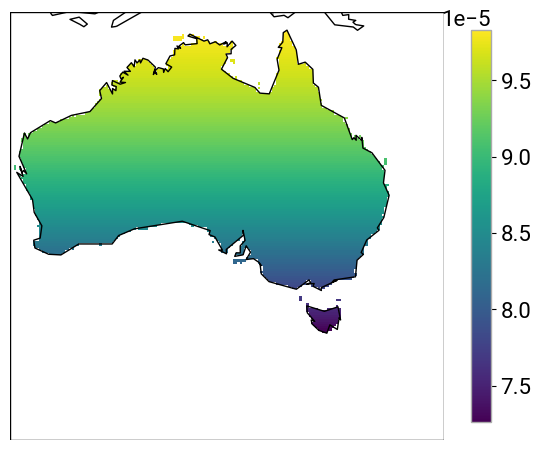

In [108]:
area_2d = calculate_gridarea(lats, res=abs(lats[1]-lats[0]), nlon=len(lons))
country_area_2d = mask * area_2d
country_area_2d[country_area_2d==0] = np.nan
country_area_total = np.nansum(country_area_2d)
if debug:
    print(country_area_total)
country_area_weights = country_area_2d/country_area_total

if debug:
    fig = plt.figure()
    m = Basemap(projection='cyl', llcrnrlon=-180, \
            urcrnrlon=180.,llcrnrlat=grid_lat.min(),urcrnrlat=grid_lat.max(), \
            resolution='c')
    x, y = m(grid_lon, grid_lat)
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    plt.xlim(xlims)
    plt.ylim(ylims)
    ax1 = m.pcolormesh(x, y, country_area_weights, shading='auto')
    plt.colorbar(ax1, orientation='vertical', shrink=0.85)
    plt.show()

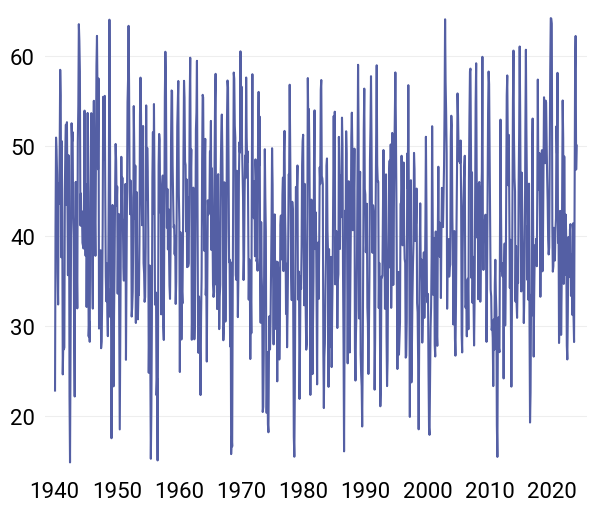

In [109]:

# print((fwi.shape[0]))
fwi_country_ts=np.zeros((fwi['fwinx'].values.shape[0]))
for it in range(len(fwi_country_ts)):
    fwi_country_ts[it] = np.nansum(fwi_country[it,:,:] * country_area_2d / country_area_total)

plt.figure()
plt.plot(dates, fwi_country_ts)
    

## Plots...

In [110]:


from IPython.display import HTML

# Generate HTML code to display the colors
html = ''.join(f'<div style="width: 100px; height: 100px; background-color: {color}; display: inline-block;"></div>' for color in color_list)

# Display the HTML
HTML(html)
# print(levels,color_list)

In [ ]:
from IPython.display import HTML

# Generate HTML code to display the colors
html = ''.join(f'<div style="width: 100px; height: 100px; background-color: {color}; display: inline-block;"></div>' for color in color_list)

# Display the HTML
HTML(html)

USING EFFIS


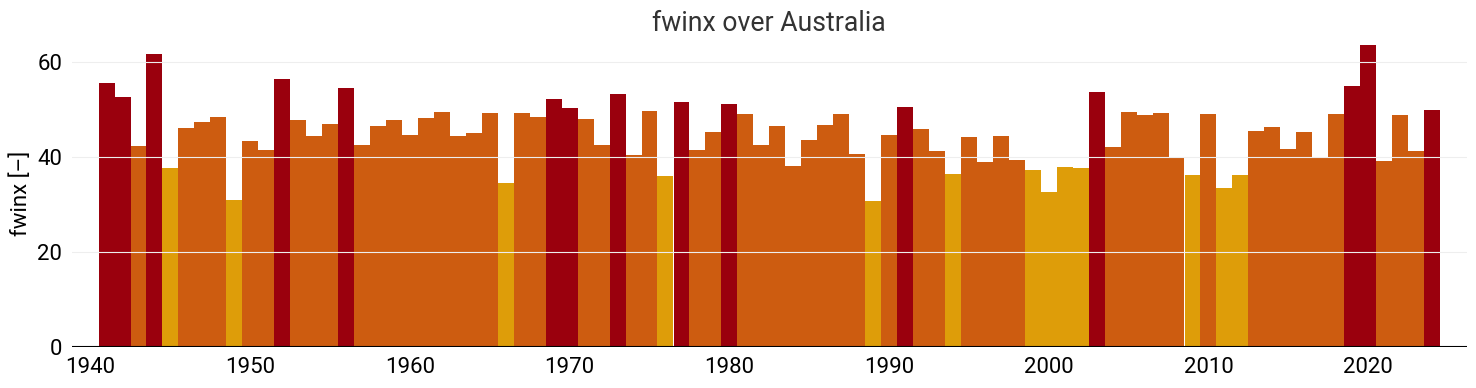

In [121]:
ivar      = f"fwinx"

plt.figure(figsize=(18,4))
x=dates[(window-1)::window]
xyear = [ix.year for ix in x]
# print(color_list)
y=list(fwi_country_ts[(window-1)::window])
# color for each spi time step, including mild categories and white between -0.1 and 0.1
# y_colors = [{np.isnan(p): color_list[0], p<=10: color_list[0], 10<p<=20: color_list[1], 20<p<=30: color_list[2], p>60: color_list[2]}[True] for p in y]
y_colors=[]
# print(y)
if use_effis_colors:
    print('USING EFFIS')
    for p in y:
        if np.isnan(p):
            y_colors.append(effis_color_list[0])  # 'red' for NaN
        elif p <= 11.2:
            y_colors.append(effis_color_list[0])  # 'red' for values <= 10
        elif 11.2 < p < 21.3:
            y_colors.append(effis_color_list[1])  # 'green' for values between 10 and 20
        elif 21.3 < p < 38:
            y_colors.append(effis_color_list[2])  # 'green' for values between 10 and 20
        elif 38 < p < 50:
            y_colors.append(effis_color_list[3])  # 'green' for values between 10 and 20
        elif 50 < p < 70:
            y_colors.append(effis_color_list[4])  # 'green' for values between 10 and 20
        elif p > 70:
            y_colors.append(effis_color_list[5])  # 'blue' for values > 60
else:
    print('USING ECCHARTS')
    y_colors=[]
    # print(y)
    for p in y:
        if np.isnan(p):
            y_colors.append(eccharts_color_list[0])  # 'red' for NaN
        elif p <= 5:
            y_colors.append(eccharts_color_list[0])  # 'red' for values <= 10
        elif 5 < p < 10:
            y_colors.append(eccharts_color_list[1])  # 'green' for values between 10 and 20
        elif 10 < p < 15:
            y_colors.append(eccharts_color_list[2])  
        elif 38 < p < 20:
            y_colors.append(eccharts_color_list[3])  
        elif 50 < p < 25:
            y_colors.append(eccharts_color_list[4])
        elif 50 < p < 30:
            y_colors.append(eccharts_color_list[5])
        elif 50 < p < 35:
            y_colors.append(eccharts_color_list[6])
        elif 50 < p < 40:
            y_colors.append(eccharts_color_list[7])
        elif 50 < p < 50:
            y_colors.append(eccharts_color_list[8])
        elif 50 < p < 60:
            y_colors.append(eccharts_color_list[9]) 
        elif p > 60:
            y_colors.append(eccharts_color_list[10]) 

plt.bar(x, y, color=y_colors, align='center', width=365/(12/window))

plt.bar(x, y, color=y_colors, align='center', width=365/(12/window))
plt.axhline(y=0, color = 'black', linestyle = '-')

plt.ylabel(f"{index} [–]")
plt.title(f"{index} over {country_name}")

# custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color_list[0], lw=4),
                Line2D([0], [0], color=color_list[1], lw=4),
                Line2D([0], [0], color=color_list[2], lw=4),
                Line2D([0], [0], color='#7F7F7F', lw=4)]

del(x)
del(y)
del(y_colors)

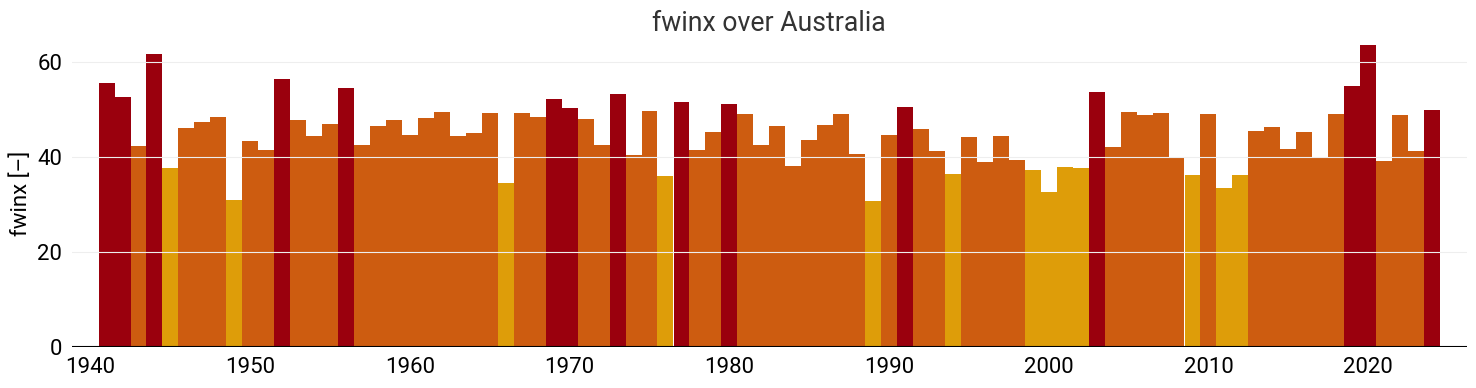

In [ ]:
ivar      = f"fwinx"
use_effis_colors=True
plt.figure(figsize=(18,4))
x=dates[(window-1)::window]
xyear = [ix.year for ix in x]
# print(color_list)
y=list(fwi_country_ts[(window-1)::window])
# color for each spi time step, including mild categories and white between -0.1 and 0.1
# y_colors = [{np.isnan(p): color_list[0], p<=10: color_list[0], 10<p<=20: color_list[1], 20<p<=30: color_list[2], p>60: color_list[2]}[True] for p in y]
y_colors=[]
# print(y)
if use_effis_colors:
    print('USING EFFIS')
    for p in y:
        if np.isnan(p):
            y_colors.append(effis_color_list[0])  # 'red' for NaN
        elif p <= 11.2:
            y_colors.append(effis_color_list[0])  # 'red' for values <= 10
        elif 11.2 < p < 21.3:
            y_colors.append(effis_color_list[1])  # 'green' for values between 10 and 20
        elif 21.3 < p < 38:
            y_colors.append(effis_color_list[2])  # 'green' for values between 10 and 20
        elif 38 < p < 50:
            y_colors.append(effis_color_list[3])  # 'green' for values between 10 and 20
        elif 50 < p < 70:
            y_colors.append(effis_color_list[4])  # 'green' for values between 10 and 20
        elif p > 70:
            y_colors.append(effis_color_list[5])  # 'blue' for values > 60
else:
    print('USING ECCHARTS')
    y_colors=[]
    # print(y)
    for p in y:
        if np.isnan(p):
            y_colors.append(eccharts_color_list[0])  # 'red' for NaN
        elif p <= 5:
            y_colors.append(eccharts_color_list[0])  # 'red' for values <= 10
        elif 5 < p < 10:
            y_colors.append(eccharts_color_list[1])  # 'green' for values between 10 and 20
        elif 10 < p < 15:
            y_colors.append(eccharts_color_list[2])  
        elif 38 < p < 20:
            y_colors.append(eccharts_color_list[3])  
        elif 50 < p < 25:
            y_colors.append(eccharts_color_list[4])
        elif 50 < p < 30:
            y_colors.append(eccharts_color_list[5])
        elif 50 < p < 35:
            y_colors.append(eccharts_color_list[6])
        elif 50 < p < 40:
            y_colors.append(eccharts_color_list[7])
        elif 50 < p < 50:
            y_colors.append(eccharts_color_list[8])
        elif 50 < p < 60:
            y_colors.append(eccharts_color_list[9]) 
        elif p > 60:
            y_colors.append(eccharts_color_list[10]) 
# print(y_colors)
# color for each spi time step, excluding mild categories and grey between -1 and 1
#y_colors = [{np.isnan(p): color_list[4], p<=-2: color_list[0], -2<p<=-1.5: color_list[1], -1.5<p<=-1: color_list[2], -1<p<1: '#7F7F7F', 1<=p<1.5: color_list[6], 1.5<=p<2: color_list[7], p>=2: color_list[8]}[True] for p in y]
plt.bar(x, y, color=y_colors, align='center', width=365/(12/window))
# print(x[xyear.index(ryyyy_end)])
# plt.axvspan(x[xyear.index(ryyyy_start)], x[xyear.index(ryyyy_end)], facecolor='#CCCCCC', alpha=0.5)
plt.bar(x, y, color=y_colors, align='center', width=365/(12/window))
plt.axhline(y=0, color = 'black', linestyle = '-')
#plt.xlabel("Date")
plt.ylabel(f"{index} [–]")
plt.title(f"{index} over {country_name}")

# custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color_list[0], lw=4),
                Line2D([0], [0], color=color_list[1], lw=4),
                Line2D([0], [0], color=color_list[2], lw=4),
                Line2D([0], [0], color='#7F7F7F', lw=4)]

del(x)
del(y)
del(y_colors)

### FWI Stripes

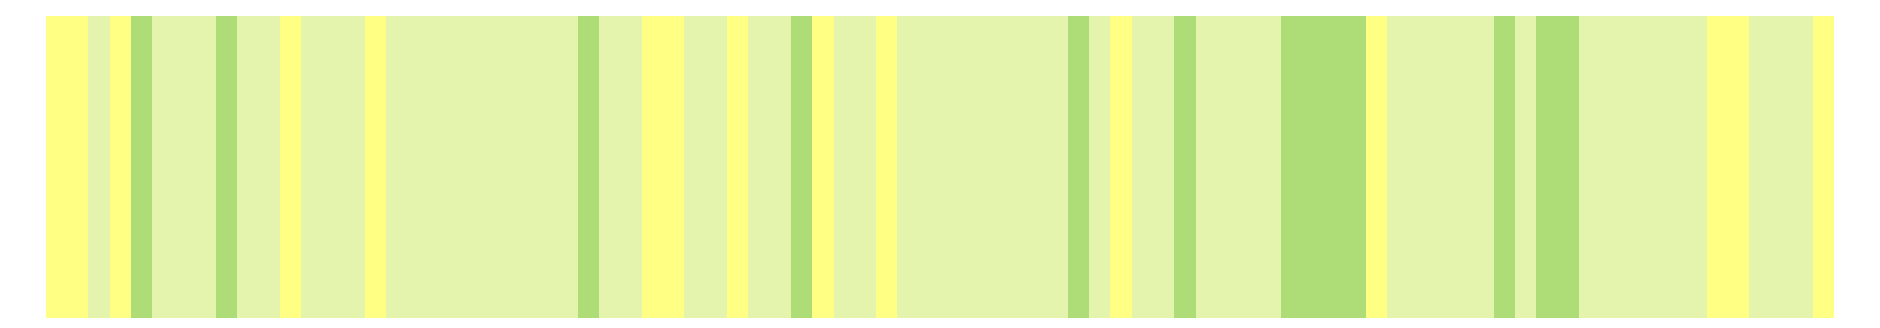

In [112]:

plt.figure(figsize=(24,4))
plt.axis('off')
x = dates[(window-1)::window]
xyear = [ix.year for ix in x]
y = list(fwi_country_ts[(window-1)::window])

    
# color for each spi time step, including mild categories and white between -0.1 and 0.1
y_colors=[]
# print(y)
for p in y:
    if np.isnan(p):
        y_colors.append(color_list[0])  # 'red' for NaN
    elif p <= 11.2:
        y_colors.append(color_list[0])  # 'red' for values <= 10
    elif 11.2 < p < 21.3:
        y_colors.append(color_list[1])  # 'green' for values between 10 and 20
    elif 21.3 < p < 38:
        y_colors.append(color_list[2])  # 'green' for values between 10 and 20
    elif 38 < p < 50:
        y_colors.append(color_list[3])  # 'green' for values between 10 and 20
    elif 50 < p < 70:
        y_colors.append(color_list[4])  # 'green' for values between 10 and 20
    elif p > 70:
        y_colors.append(color_list[5])  # 'blue' for values > 60
# color for each spi time step, excluding mild categories and grey between -1 and 1
#y_colors = [{np.isnan(p): color_list[4], p<=-2: color_list[0], -2<p<=-1.5: color_list[1], -1.5<p<=-1: color_list[2], -1<p<1: '#7F7F7F', 1<=p<1.5: color_list[6], 1.5<=p<2: color_list[7], p>=2: color_list[8]}[True] for p in y]
plt.bar(x, np.repeat(1, len(x)), color=y_colors, align='center', width=365/(12/window))
#fig.axes.get_xaxis().set_visible(False)
#fig.axes.get_yaxis().set_visible(False)
plt.savefig(f"{country_name}_{index}{window}.png", facecolor="white",  edgecolor='none')
plt.savefig(f"{country_name}_{index}{window}.pdf", facecolor="white",  edgecolor='none')
